### Augmentation Script

The purpose of this script is to demonstrate how the augmentation logic in the Wayne_RPE dataset work.

The following code just ensures we run the notebook with the project directory as the working directory:

In [75]:
import os
from pathlib import Path

nb_path = Path().resolve()
proj_dir = nb_path.parent

os.chdir(proj_dir)

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home


In [76]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tifffile as tiff

from scipy import ndimage

from src.datasets import find_center_mask, get_min_max_axis, normalize_image
from src.helpers import _determine_slurm

We can start by loading a sample image as a tiff file:

Text(0.5, 1.0, 'Cell 0002, Z=10 (DNA1)')

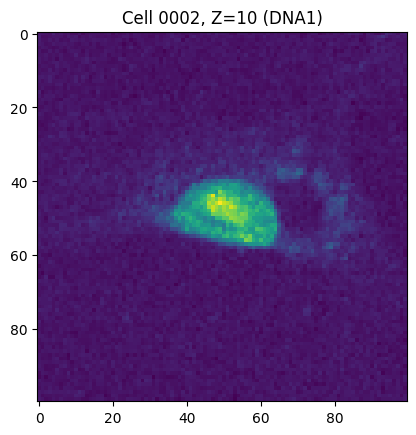

In [77]:
FILEPATH = "/nas/longleaf/home/oem/PHASER/pytorch/data/phaser_rpe/raw/images/cell_0002.tif" if _determine_slurm() else "/home/omar/projects/unc/PHASER/pytorch/data/phaser_rpe/raw/images/cell_0006.tif" 
image = tiff.imread(FILEPATH)
image = tf.convert_to_tensor(image)
image = normalize_image(image)

plt.imshow(image[:, :, 10])
plt.title("Cell 0002, Z=10 (DNA1)")

Next, we need to find the middle-most masks in this image and create new binary masks withy only the center-most masks. We append these masks to the tensor along with a combined version of the original nuc and ring masks, as well as the centered ones.

Original shape: (100, 100, 59)
New shape: (100, 100, 63)


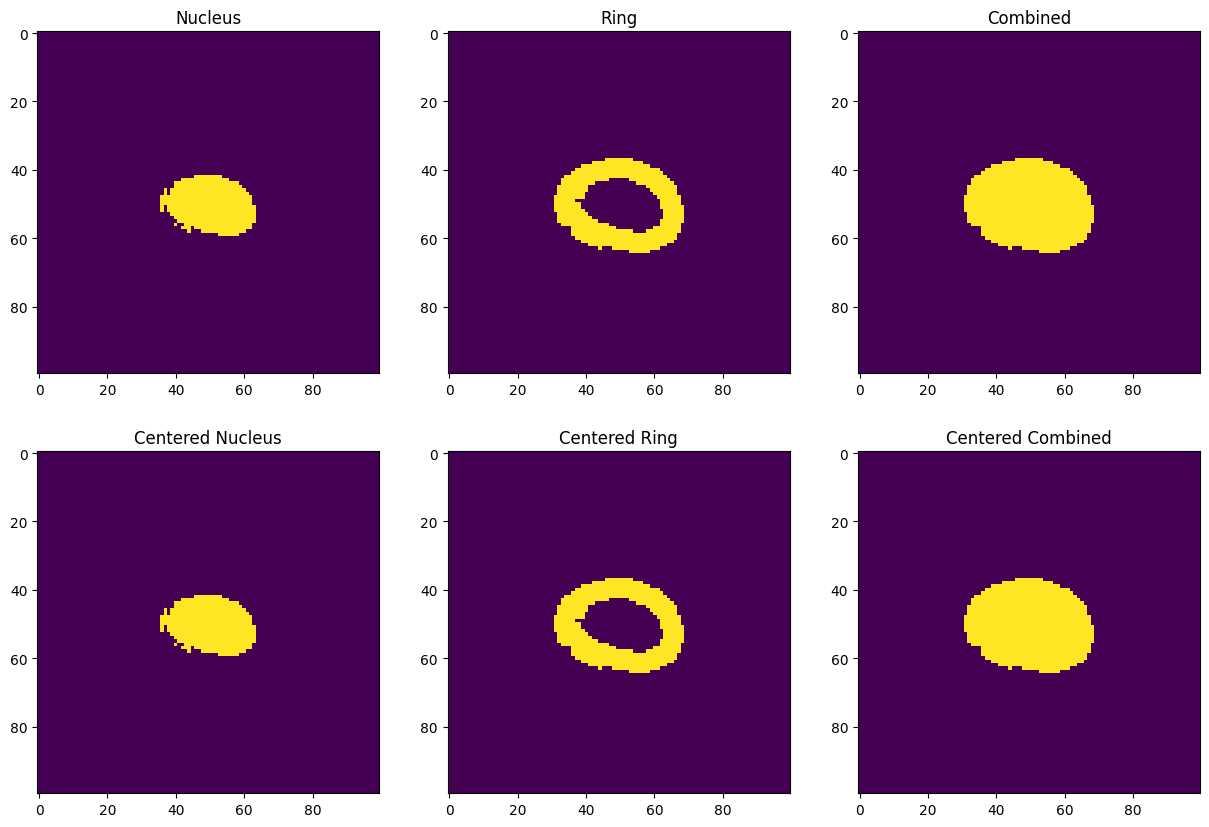

In [78]:
print('Original shape:', image.shape)

nuc = tf.not_equal(image[:, :, 57], 0.0)
ring = tf.not_equal(image[:, :, 58], 0.0)
combined = tf.logical_or(nuc, ring)

orig_masks = [nuc, ring, combined]
centered_masks = [find_center_mask(mask) for mask in orig_masks]

all_masks = orig_masks + centered_masks
titles = ["Nucleus", "Ring", "Combined", "Centered Nucleus", "Centered Ring", "Centered Combined"]

masks_to_add = tf.stack(all_masks[2:], axis=-1)
masks_to_add = [tf.cast(mask, tf.float32) for mask in masks_to_add]
image = tf.concat([image, masks_to_add], axis=2)

print('New shape:', image.shape) 

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, mask in enumerate(all_masks):
    ax = axs[i // 3, i % 3]
    ax.imshow(mask)
    ax.set_title(titles[i])

The masks above show the positions of cell nuclei, cytoplasm rings, and the nucleus+cytoplasm ring. The top row shows the positions of all cells in the image, whereas the bottom image shows the centermost cell, or the cell of interest (i.e., the cell that this image is annotated to describe). 

Now, if augmentations are enabled, we augment by rotating and shifting. We rotate first:

Text(0.5, 1.0, 'Rotated Mask, Angle=160')

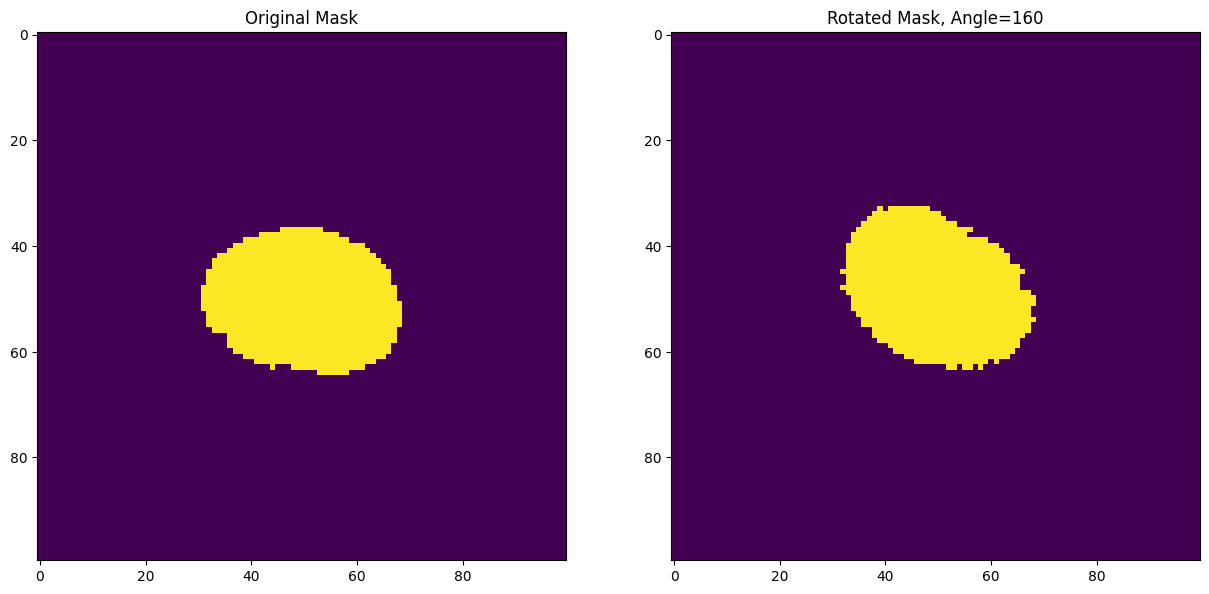

In [79]:
# Get a random angle to rotate to
angle = np.random.randint(0, 360)
image_np = image.numpy()

image_np_rot = ndimage.rotate(image_np, angle, axes=[0, 1], 
                              reshape=False, order=0)
image_rot = tf.convert_to_tensor(image_np_rot, dtype=tf.float32)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image[:, :, 62])
axs[0].set_title("Original Mask")
axs[1].imshow(image_rot[:, :, 62])
axs[1].set_title(f"Rotated Mask, Angle={angle}")



The centered mask above shows how the center cell is rotated in the image. If we look at one of the other channels, such as DNA, we can see that rotation leaves some artefacts in the image (we will deal with this later):

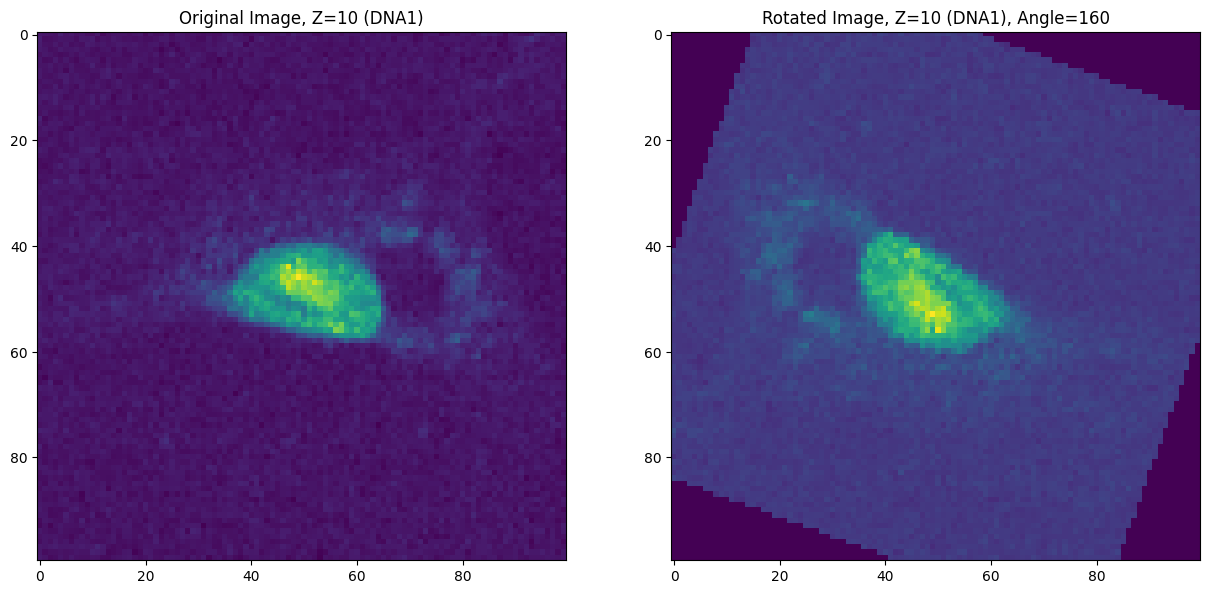

In [80]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image[:, :, 10])
axs[0].set_title("Original Image, Z=10 (DNA1)")
axs[1].imshow(image_rot[:, :, 10])
axs[1].set_title(f"Rotated Image, Z=10 (DNA1), Angle={angle}")

image = image_rot

Now, we can translate the image. We can use the combined mask (or the ring mask) to define the maximum shifts we can make without cutting off the cell nucleus. To do this we use the `_get_min_max_axis()` function from `datasets.py`:

In [81]:
ymin, ymax, xmin, xmax = get_min_max_axis(image[:, :, 62])

print(f"Y Shifts: ({ymin}, {ymax})")
print(f"X Shifts: ({xmin}, {xmax})")

Y Shifts: (-33, 37)
X Shifts: (-32, 32)


Now we normally would pick random values to shift the cell around, however, we want to make sure that the maximum shifts in either direction don't end up rolling the cell across the ends of the image.

In other words, this is what  we DON'T want:

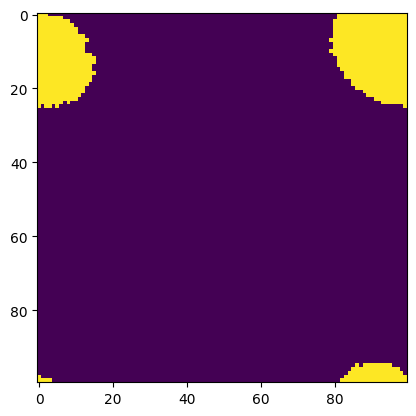

In [82]:
image_bad_shift = tf.roll(image, shift=[ymin-5, xmax+15], axis=[0, 1])

plt.imshow(image_bad_shift[:, :, 62])

So, we make sure that if we pass our min and max x, y shifts, the above won't happen:

Text(0.5, 1.0, 'Max Shifted Mask')

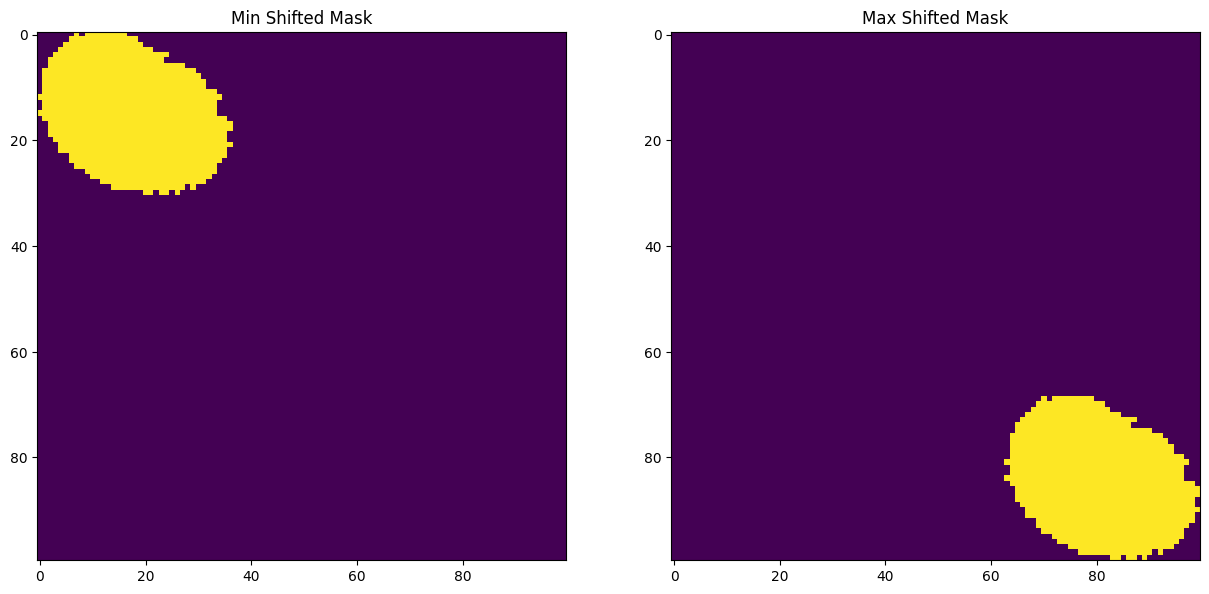

In [83]:
min_shift = tf.roll(image, shift=[ymin, xmin], axis=[0, 1])
max_shift = tf.roll(image, shift=[ymax-1, xmax-1], axis=[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(min_shift[:, :, 62])
axs[0].set_title("Min Shifted Mask")
axs[1].imshow(max_shift[:, :, 62])
axs[1].set_title(f"Max Shifted Mask")

**Note: you may have noticed that we subtract 1 from the max shifts. This is intentional and isn't cheating as when we pick a random value in the next code block, the `np.random.randint()` function is exlcusive of the higher value. Therefore, it will never pick that value (or anything higher).

As we can see above, the shifts move the cell to the extreme values of each axis without shifting them off the image. 

Now we can just pick a random X and Y shift from between these values and apply it:

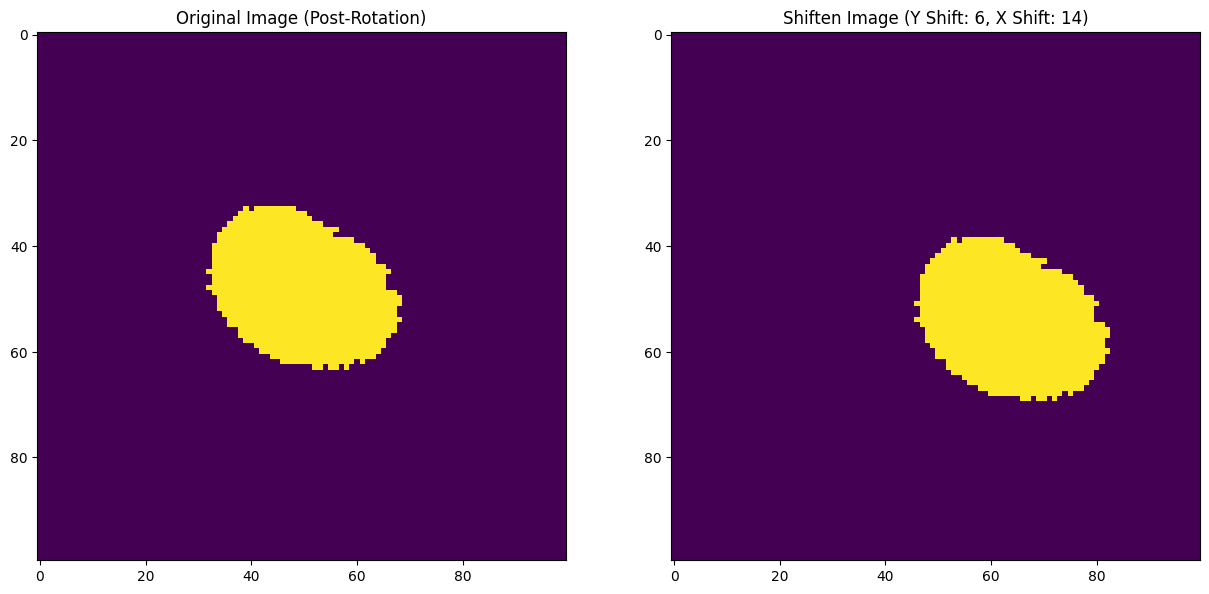

In [84]:
xshift = np.random.randint(low=xmin, high=xmax)
yshift = np.random.randint(low=ymin, high=ymax)

image_shifted = tf.roll(image, shift=[yshift, xshift], axis=[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(image[:, :, 62])
axs[0].set_title("Original Image (Post-Rotation)")
axs[1].imshow(image_shifted[:, :, 62])
axs[1].set_title(f"Shiften Image (Y Shift: {yshift}, X Shift: {xshift})")

image = image_shifted

Our augmentation is pretty much done at this point. However, as previously noted the rotation, and now the shift, have left artefacts in our image:

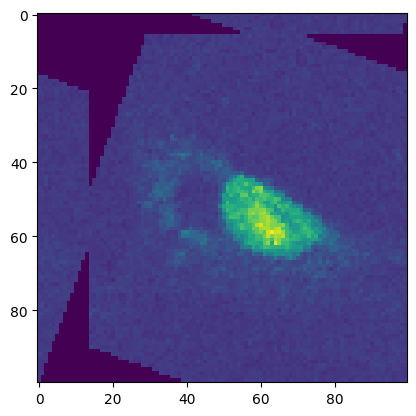

In [85]:
plt.imshow(image[:, :, 10])

We have a number of ways to deal with this. The first (and easiest way) is to simply mask out everything that is not the cell of interest. All of the masks are part of the image tensor, so all the same rotations and shifts were applied to them. We can use either the nucleus mask or the combined nucleus+ring mask.

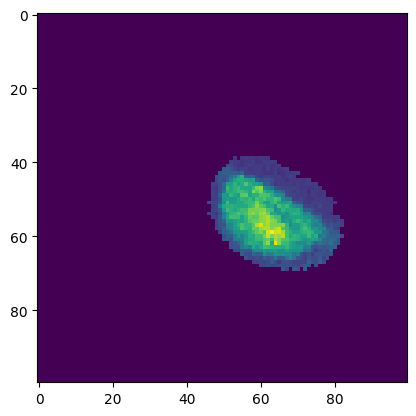

In [86]:
mask_to_apply = image[:, :, 62]
mask_to_apply = tf.expand_dims(mask_to_apply, axis=-1)
mask_to_apply = tf.tile(mask_to_apply, [1, 1, 58])

# We don't want to apply the mask to any of the other masks,
# so we only do this up to slice 58 (the last non-mask slice)
# (we actually apply the masks in the real code to all slices because
# we handle this differently).
slices = image[:, :, :58]
masked_slices = slices * tf.cast(mask_to_apply, slices.dtype)

image_masked = tf.concat([masked_slices, image[:, :, 58:]], axis=-1)

plt.imshow(image_masked[:, :, 10])

Now this leaves everything outside of the cell as a zero value pixel. This, of course, isn't exactly realistic. One thing we can do is intelligently sample pixel values to fill in the zeros from the original image. When we do that we need to make sure that we are not capturing pixels from inside the cell nuclei nor any zero pixels.

First, we invert our non-centered combined masks so that we are now excluding cells.

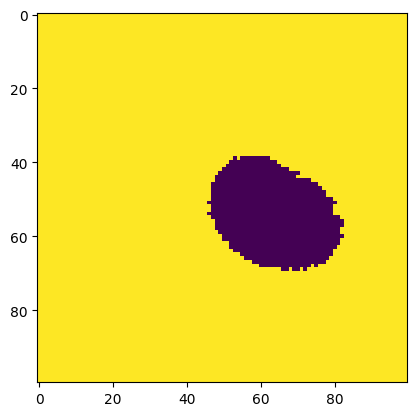

In [87]:
inv_mask = 1 - image[:, :, 59]
inv_mask = tf.expand_dims(inv_mask, axis=-1)
inv_mask = tf.tile(inv_mask, [1, 1, 57])
inv_mask_np = inv_mask.numpy()

plt.imshow(inv_mask_np[:, :, 1])

Now we can create an array of values to sample from for each slice

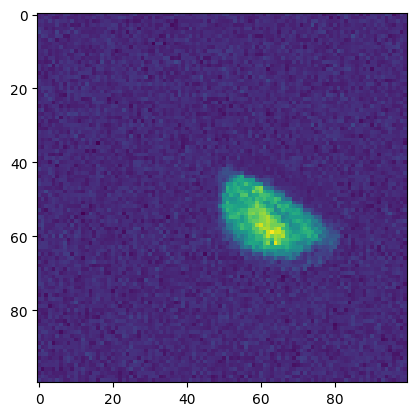

In [88]:
sample_from = tf.identity(image[:, :, :57])

# apply the inverted mask
sample_from = sample_from * tf.cast(inv_mask, sample_from.dtype)

# Calculate the mean and standard deviation for each channel
means = [tf.math.reduce_mean(tf.boolean_mask(sample_from[:, :, i], sample_from[:, :, i != 0])) for i in range(sample_from.shape[-1])]
stddevs = [tf.math.reduce_std(tf.boolean_mask(sample_from[:, :, i], sample_from[:, :, i] != 0)) for i in range(sample_from.shape[-1])]

# Get the areas that are zero in the masked images
zeros = tf.equal(image, 0)

# We fill the values with a random value sampled from 1 stdev from the median. 
# we can also vary this
def fill_zeros(image, mean, stddev):
    zero_idx = tf.where(tf.equal(image, 0))
    if tf.size(zero_idx) > 0:
        random_vals = tf.random.normal([tf.shape(zero_idx)[0]], mean=mean, stddev=stddev, dtype=tf.float32)
        filled = tf.tensor_scatter_nd_update(image, zero_idx, random_vals)
        return filled
    
    return image

# Fill zeros in each channel
filled_slices = [tf.expand_dims(fill_zeros(image_masked[:, :, i], means[i], stddevs[i]), axis=-1) for i in range(len(medians))]
filled_slices = tf.concat(filled_slices, axis=-1)

# Combine the filled slices with the rest of the image
image_masked_filled = tf.concat([filled_slices, image_masked[:, :, len(filled_slices):]], axis=-1)

# Display the filled image for visualization
plt.imshow(image_masked_filled[:, :, 10])
plt.show()